# Assignment - train and evaluate a Semantic Segmentation network

A stakeholder in your company (a small town in Germany) has identified a potential application of UAVs (unmanned aerial vehicles) for the detection of illegally parked cars in their city center. After some initial testing, the company has gathered and annotated a small dataset of images taken from UAVs.

In this assignment, you are asked to setup, train and evaluate a _simple_ semantic segmentation network.

**IMPORTANT:** The focus of this assignment is to show your knowledge, problem-solving mindset and (clean) coding skills. Do not spend too much time getting the best possible model performance, and focus instead on presenting your code and results in a clear and effective manner.

Please make use of this notebook to show the different steps you took to process the data, the architecture and training choices you made, the difficulties you encountered through the process and how you (tried to) overcome them.


In [ ]:
# !pip install -q opencv-python-headless
# !pip install -q matplotlib
# !pip install -q pandas
# !pip install -q tqdm
# !pip install -U albumentations
# !pip install -qq segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.9 MB/s eta 0:00:00


# General ideas

- Look for similar problems on the internet
- Look for related datasets (or datasets with similar domain)

# Install requirements

In [ ]:
# !nvidia-smi
# Depending on your CUDA version, select the appropriate PyTorch version
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
# !pip install -q opencv-python-headless
# !pip install -q matplotlib
# !pip install -q pandas
# !pip install -q tqdm
# !pip install -U albumentations
# !pip install -q segmentation-models-pytorch

### 3. Data processing pipeline
Create a processing pipeline (function, generator, class) that can feed the data to the model during training.
What augmentations do you perform, and why? 

In [84]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from tqdm import tqdm
import segmentation_models_pytorch as smp
import torch.optim as optim

from typing import List, Optional, Tuple

# Preprocessing

The provided dataset for this assignment is a high-resolution UAV semantic segmentation dataset focusing on street scenes.

The dataset can be found in the same folder as these notebooks are in. Please let us immediately know if there's any issue with the data files.

### 1. Load the data


The 8 classes and corresponding label color (R,G,B) are as follows:

|        Class       | RGB          |
|:------------------:|--------------|
| Background clutter | (0,0,0)      |
| Building           | (128,0,0)    |
| Road               | (128,64,128) |
| Tree               | (0,128,0)    |
| Low vegetation     | (128,128,0)  |
| Moving car         | (64,0,128)   |
| Static car         | (192,0,192)  |
| Human              | (64,64,0)    |

In [54]:
COLOR_TO_CLASS = {
    (0, 0, 0): 0,         # Background clutter
    (128, 0, 0): 1,       # Building
    (128, 64, 128): 2,    # Road
    (0, 128, 0): 3,       # Tree
    (128, 128, 0): 4,     # Low vegetation
    (64, 0, 128): 5,      # Moving car
    (192, 0, 192): 6,     # Static car
    (64, 64, 0): 7        # Human
}
CLASS_TO_LABEL = {
    0: "Background",
    1: "Building",
    2: "Road",
    3: "Tree",
    4: "Low vegetation",
    5: "Moving car",
    6: "Static car",
    7: "Human"
}

In [71]:
data_path = "../uav_seg_full/uav_seg/"

In [ ]:
def convert_mask_to_index(mask: np.ndarray) -> np.ndarray:
    """
    Convert an RGB segmentation mask to a class index mask.

    Args:
        mask (np.ndarray): RGB mask.

    Returns:
        np.ndarray: Indexed mask with values from 0 to num_classes-1.
    """
    indexed_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    
    for rgb, class_index in COLOR_TO_CLASS.items():
        mask_pixels = (mask[:, :, 0] == rgb[0]) & (mask[:, :, 1] == rgb[1]) & (mask[:, :, 2] == rgb[2])
        indexed_mask[mask_pixels] = class_index

    return indexed_mask

def load_sample(data_path: str, sample_id: int) -> List[np.ndarray]:
    """
    Basic sample loading.
    sample_id is a number (type int or str) that refers to the image and mask names:
    Image: 1.png, Mask: 1.png => sample_id: 1

    Returns: Y:X:C numpy arrays
    """
    image_path = os.path.join(data_path, "Images", str(sample_id)+".png")
    mask_path = os.path.join(data_path, "Labels", str(sample_id)+".png")

    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        print(f"Warning: Sample {sample_id} not found.")
        return None
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_converted = convert_mask_to_index(mask)
    return image, mask_converted

def visualize_sample(image, mask) -> None:
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

tmp_img, tmp_mask = load_sample(data_path, 6)
tmp_img.shape, tmp_mask.shape


((1024, 1024, 3), (1024, 1024))

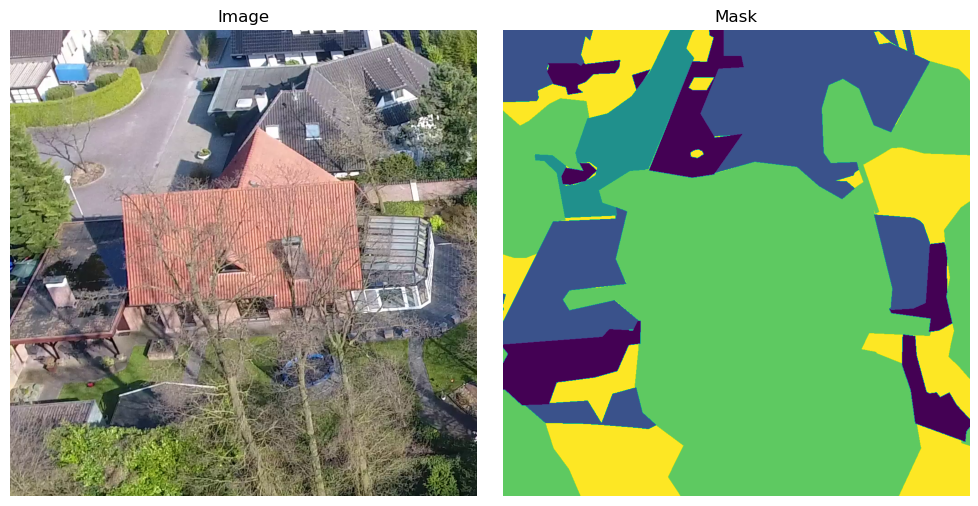

In [73]:
visualize_sample(tmp_img, tmp_mask)

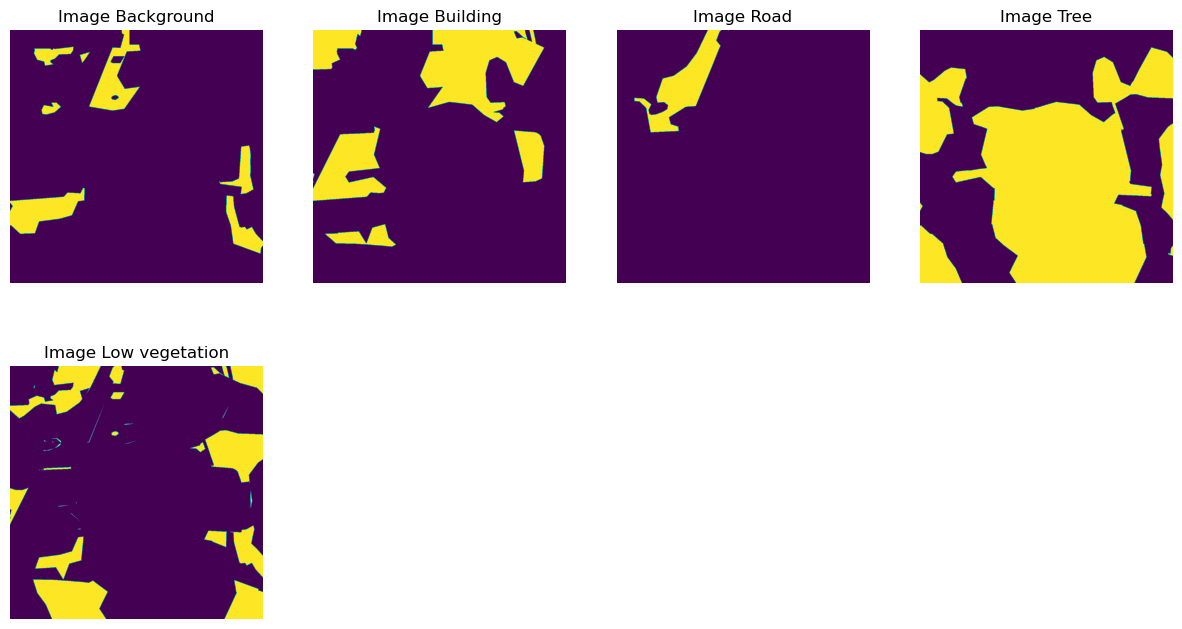

In [74]:
tmp_masks = [(x, tmp_mask==x) for x in np.unique(tmp_mask)]

plt.figure(figsize=(15, 8))
for i, img in tmp_masks:
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Image {CLASS_TO_LABEL[i]}')
    plt.axis('off')

### 2. Explore the dataset
Take some time a look at the data, and show all the information that you might find relevant.
Split the data in training, validation and testing set. 

#### Plan:

- Visualize some data to find possible problems
- Research class balance (sample-wise and pixel-wise)
- Propose possible augmentations

#### Visualize data

##### Idea 1
There are thin lines and areas on the image that may be difficult to recognize. Data preprocessing, namely morphologies, may fix this issue

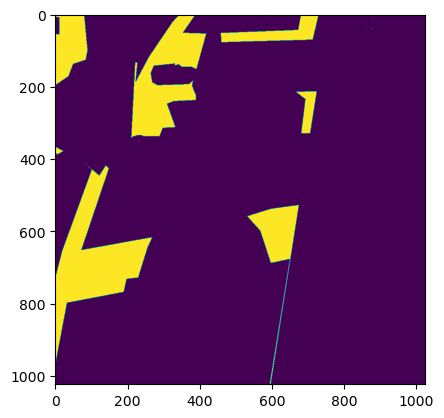

In [ ]:
tmp_img, tmp_mask = load_sample(data_path, 0)
plt.imshow(tmp_mask==0)

##### Idea 2:

Trees are displayed both with leaves and without, the segmentation may confuse the model (like in sample 0)
Imagine a car standing behind the tree. (example)
Common overlapping issues occur here. It would be better to solve the multilabel segmentation instead of multiclass. (need to remake labels here).
I would suggest implementing more advanced feature engineering approach (get more data with trees of various kinds, intoduce multiple tree classes)

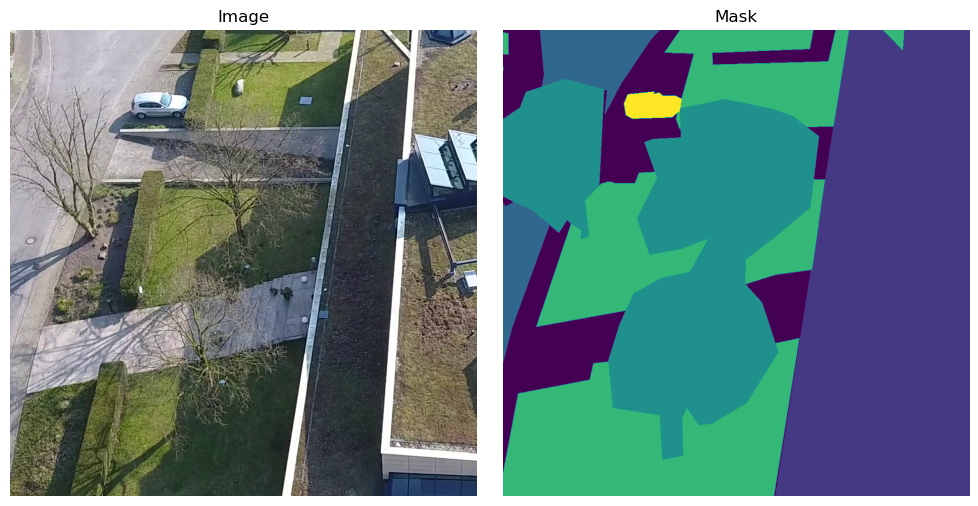

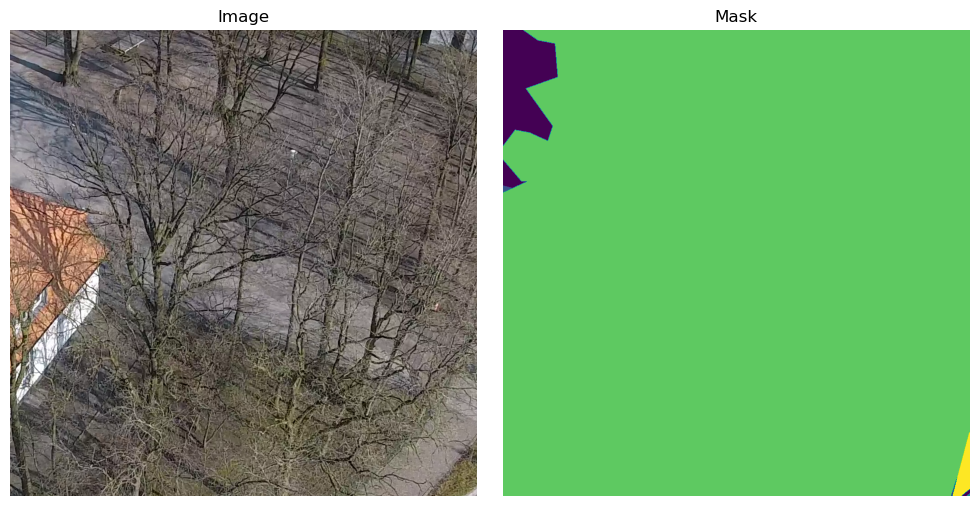

In [ ]:
tmp_img, tmp_mask = load_sample(data_path, 0)
visualize_sample(tmp_img, tmp_mask)

tmp_img, tmp_mask = load_sample(data_path, 247)
visualize_sample(tmp_img, tmp_mask)

##### Idea 3
It may be difficult to differentiate the moving and the static cars. 
A good feature here may be a series of images (we could estimate the movement of the car compared to the scenery).
Potential solution: merge cars into a single class for this model and train another model (keypoint detection) that will work with image series
Or a video stream and define wether the car is moving or not. The issue of a car standing on the red light still may persist.

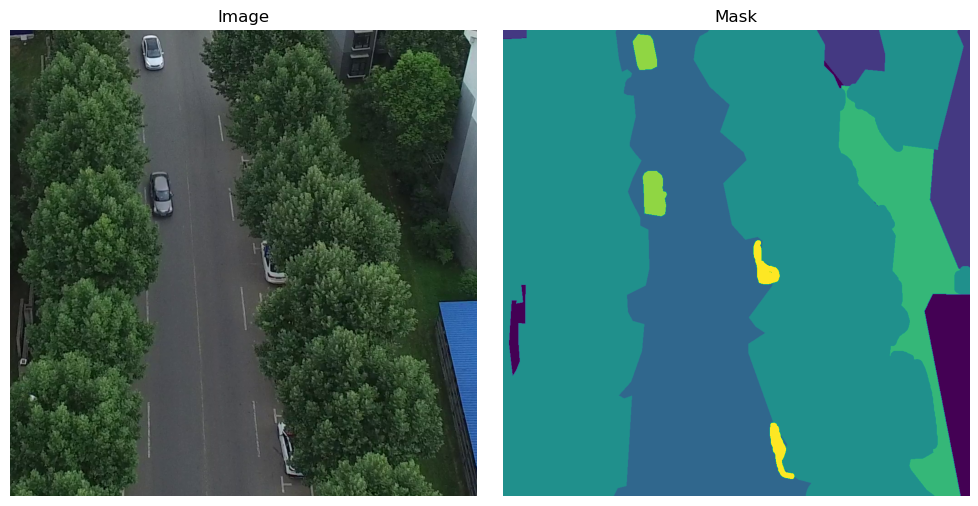

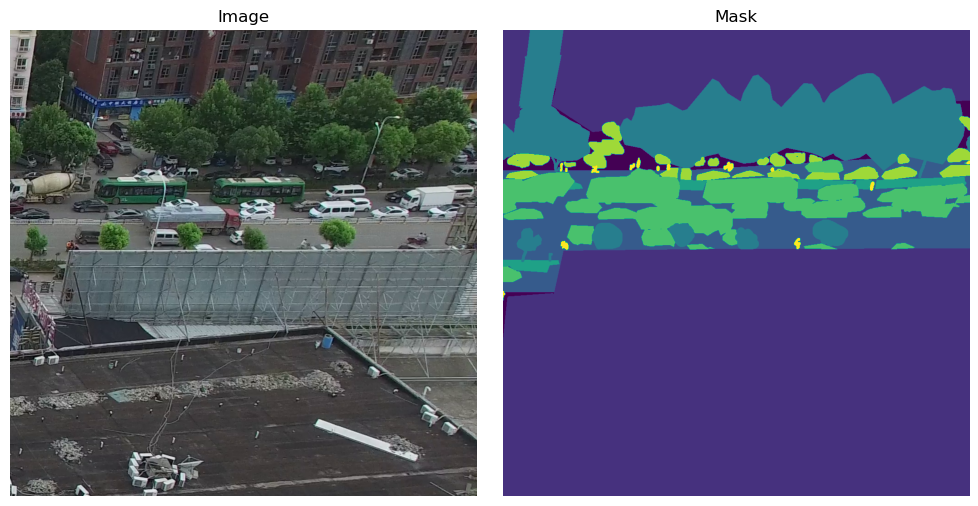

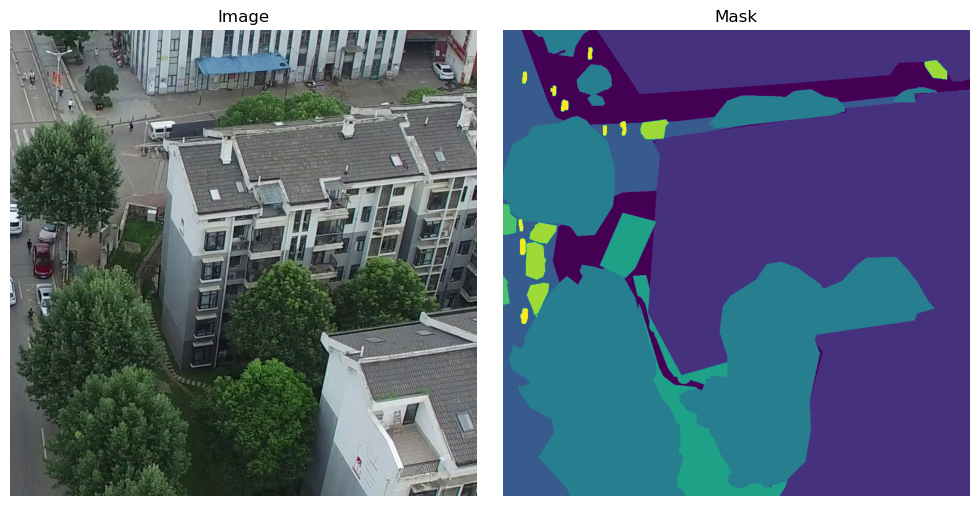

In [ ]:
tmp_img, tmp_mask = load_sample(data_path, 10)
visualize_sample(tmp_img, tmp_mask)

tmp_img, tmp_mask = load_sample(data_path, 11)
visualize_sample(tmp_img, tmp_mask)

tmp_img, tmp_mask = load_sample(data_path, 12)
visualize_sample(tmp_img, tmp_mask)

#### Estimate class balance

In [82]:
class_stats = []

for i in tqdm(range(270)):
    
    sample_stats = {"sample_id": i}
    img, mask = load_sample(data_path, i)

    for cls in CLASS_TO_LABEL.keys():
        # Estimate pixelwise balance
        cls_pixels = np.sum((mask==cls).astype(np.int16))
        sample_stats[f"pixel_stats_{cls}"] = cls_pixels
        
        # Estimate classwise balance
        sample_stats[f"sample_stats_{cls}"] = 1 if cls in np.unique(mask) else 0
    
    class_stats.append(sample_stats)

100%|██████████| 270/270 [00:31<00:00,  8.70it/s]


In [85]:
cls_stats = pd.DataFrame(class_stats)
cls_stats.to_csv("./class_stats.csv", index=False)
cls_stats.head()

sample_id  pixel_stats_0  sample_stats_0  pixel_stats_1  sample_stats_1  \
0          0         119536               1         353132               1   
1          1         101911               1         352850               1   
2          2              0               0              0               0   
3          3          84691               1          60090               1   
4          4         260717               1         154688               1   

   pixel_stats_2  sample_stats_2  pixel_stats_3  sample_stats_3  \
0          44721               1         266937               1   
1              0               0         359178               1   
2              0               0              0               0   
3          45855               1         494418               1   
4              0               0          14293               1   

   pixel_stats_4  sample_stats_4  pixel_stats_5  sample_stats_5  \
0         258020               1              0               0   
1         234637               1              0               0   
2        1048576               1              0               0   
3         363522               1              0               0   
4         618878               1              0               0   

   pixel_stats_6  sample_stats_6  pixel_stats_7  sample_stats_7  
0           6230               1              0               0  
1              0               0              0               0  
2              0               0              0               0  
3              0               0              0               0  
4              0               0              0               0

In [86]:
for i in range(8):
    print(cls_stats[f"sample_stats_{i}"].value_counts())

# Generally classes 5: "Moving car", 6: "Static car", 7: "Human" are less frequent in the dataset.

sample_stats_0
1    265
0      5
Name: count, dtype: int64
sample_stats_1
1    215
0     55
Name: count, dtype: int64
sample_stats_2
1    201
0     69
Name: count, dtype: int64
sample_stats_3
1    263
0      7
Name: count, dtype: int64
sample_stats_4
1    241
0     29
Name: count, dtype: int64
sample_stats_5
0    150
1    120
Name: count, dtype: int64
sample_stats_6
1    162
0    108
Name: count, dtype: int64
sample_stats_7
0    139
1    131
Name: count, dtype: int64


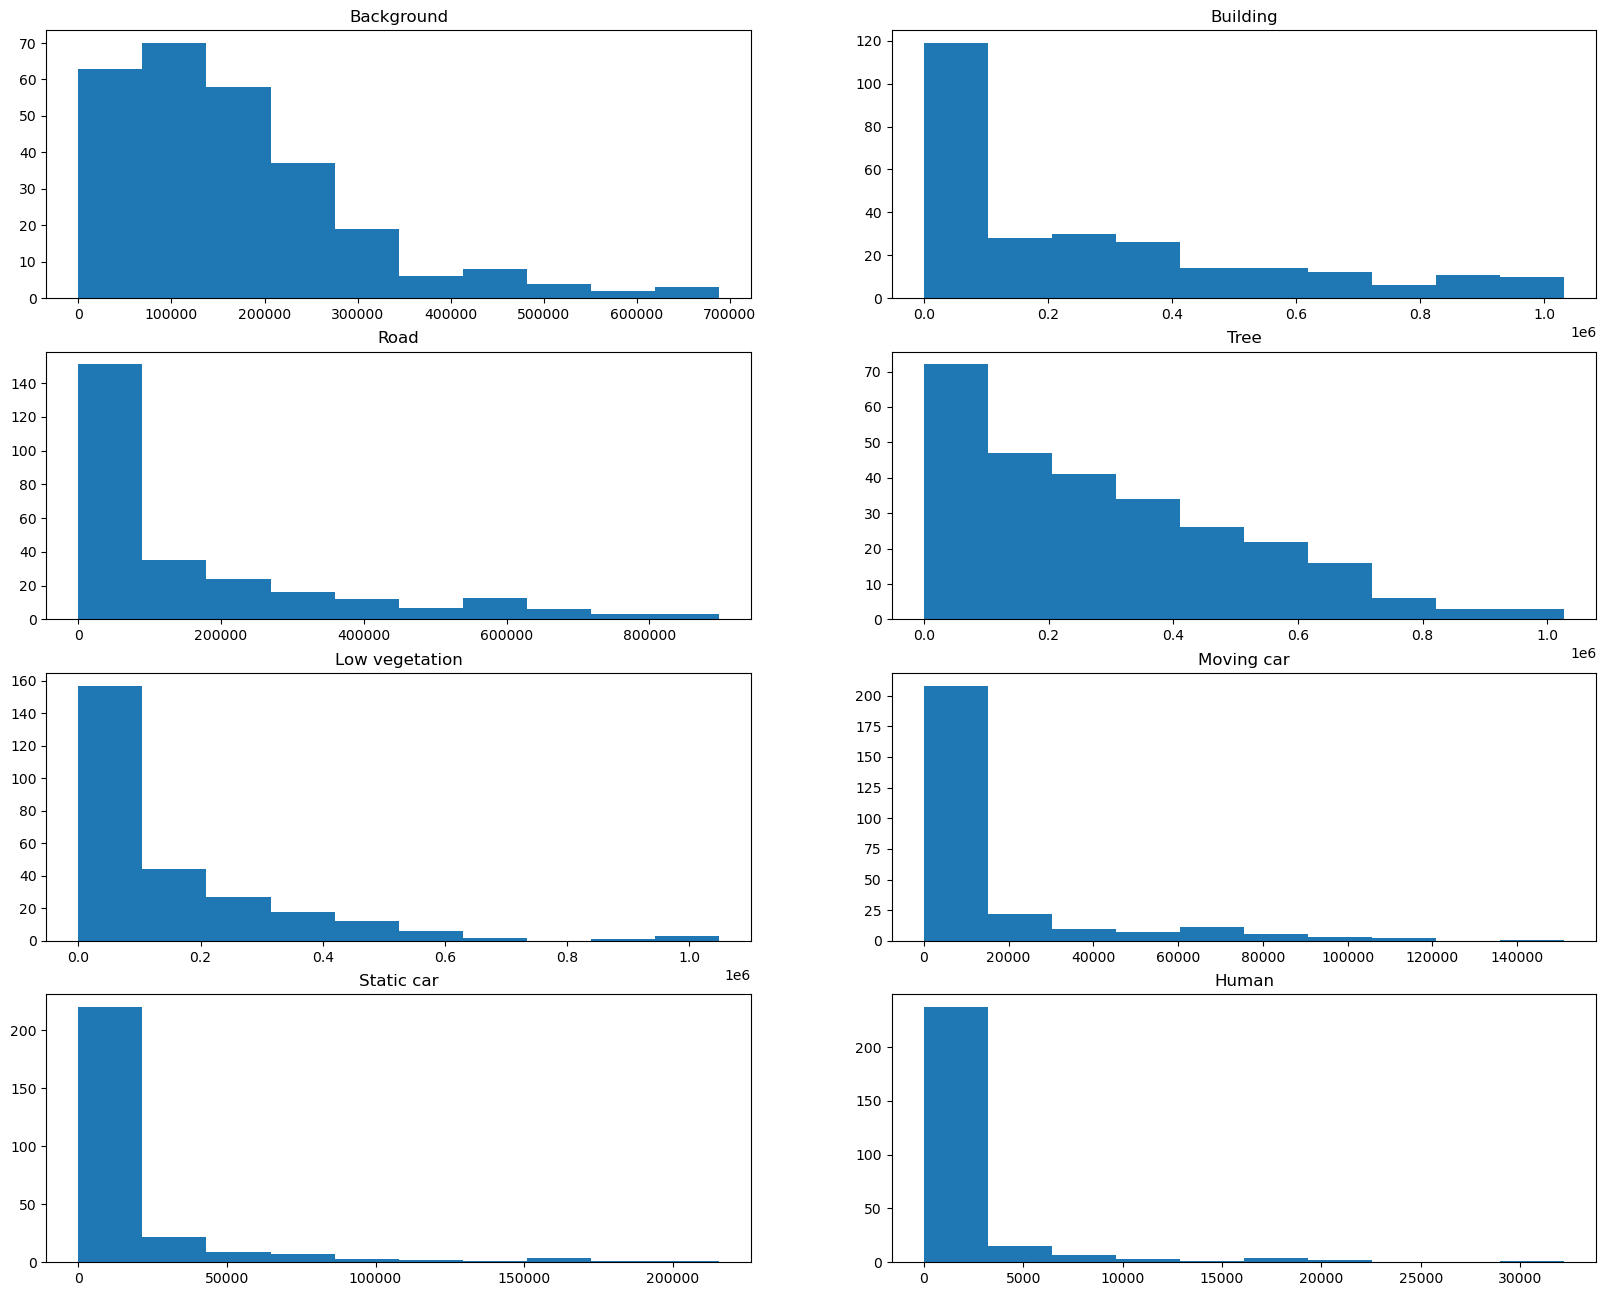

In [87]:
plt.figure(figsize=(20, 16))
for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.hist(cls_stats[f"pixel_stats_{i}"])
    plt.title(f'{CLASS_TO_LABEL[i]}')

Some objects have a small size (static and moving cars, humans) which could pose the problem to segmentation
There is also class imbalance

Ideas:
- Increase the input data resolution
- Add augmentations and oversampling for rare classes
- Use Focal Loss and/or CrossEntropy
- Loss function with weights
- Instance segmentation + semantic (instance for small objects, semantic for classes)

### 3. Data processing pipeline
Create a processing pipeline (function, generator, class) that can feed the data to the model during training.
What augmentations do you perform, and why? 

In [ ]:
class UAVSegmentationDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.image_dir = os.path.join(data_path, "Images")
        self.mask_dir = os.path.join(data_path, "Labels")
        self.image_filenames = [f for f in os.listdir(self.image_dir) if f.endswith(".png")]
        self.transform = transform
        
        self.class_colors = {
            (0, 0, 0): 0,        # Background
            (128, 0, 0): 1,      # Building
            (128, 64, 128): 2,   # Road
            (0, 128, 0): 3,      # Tree
            (128, 128, 0): 4,    # Low vegetation
            (64, 0, 128): 5,     # Moving car
            (192, 0, 192): 6,    # Static car
            (64, 64, 0): 7       # Human
        }
    
    def __len__(self):
        return len(self.image_filenames)
    
    def mask_to_class(self, mask):
        h, w, _ = mask.shape
        mask_class = np.zeros((h, w), dtype=np.uint8)
        for rgb, class_id in self.class_colors.items():
            mask_class[(mask == rgb).all(axis=2)] = class_id
        return mask_class
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.mask_to_class(mask)
        mask = np.expand_dims(mask, axis=-1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask[0,:,:]

# Here we will begin with the most basic and "Safe" 
# and continue by applying stronger augmentations
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

val_transform = A.Compose([
    A.Resize(512, 512),
])

train_dataset = UAVSegmentationDataset(data_path="../uav_seg/train", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)

val_dataset = UAVSegmentationDataset(data_path="../uav_seg/val", transform=val_transform)
val_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

test_dataset = UAVSegmentationDataset(data_path="../uav_seg/test", transform=val_transform)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

In [5]:
len(train_dataset.image_filenames), len(val_dataset.image_filenames), len(test_dataset.image_filenames)

(189, 40, 41)

# Model 
### Architecture
Pick a model architecture and ajdust it as needed for the given task. We suggest you:

1. Start small and simple: Easier to debug and faster to train. You can always try out a bigger cooler model afterwards if you have time.
2. Utilize the internet: we don't expect you to write each layer from scratch. Feel free to copypaste all you need
3. Elucidate your choices: reference the paper(s) that introduced this model and/or layers

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class UNetSegmentation(nn.Module):
    def __init__(self, encoder_name="resnet34", num_classes=8, pretrained=True):
        super(UNetSegmentation, self).__init__()
        
        self.model = smp.Unet(
            encoder_name=encoder_name,
            # Our domain is close to the imagenet, so we could use a pretrained model.
            encoder_weights="imagenet" if pretrained else None, 
            in_channels=3, 
            classes=num_classes
        )
    
    def forward(self, x):
        return self.model(x)

num_classes = 8

model = UNetSegmentation(encoder_name="resnet34", num_classes=num_classes, pretrained=True)
model.to(device);


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 396MB/s]


### Loss
What loss function are you using? Why? 


(Bonus) create a custom loss function

In [ ]:

def dice_loss(pred, target, smooth=1e-5):
    pred = F.softmax(pred, dim=1)
    target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
    intersection = torch.sum(pred * target_one_hot, dim=(2, 3))
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(target_one_hot, dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
    
    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        dice = dice_loss(pred, target)
        return self.alpha * ce + (1 - self.alpha) * dice

criterion = CombinedLoss(alpha=0.5)


### Optimizer
Elucidate your optimizer choice. Mention a couple of alternatives

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-5

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training
Train the model on the training data. Make sure to store the training progress, and visualize it afterwards.


In [ ]:

def dice_score(pred, target, smooth=1e-5):
    pred = F.softmax(pred, dim=1)
    target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
    
    intersection = torch.sum(pred * target_one_hot, dim=(2, 3))
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(target_one_hot, dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    for images, masks in tqdm(dataloader, leave=False):
        
        images = images.to(device)
        masks = masks.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_dice += dice_score(outputs, masks)
    
    return running_loss / len(dataloader), running_dice / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, leave=False):
            images, masks = images.to(device), masks.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_score(outputs, masks)
    
    return val_loss / len(dataloader), val_dice / len(dataloader)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice = validate(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f} - Val Loss: {val_loss:.4f} - Val Dice: {val_dice:.4f}")
        
        if scheduler:
            scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")


In [13]:
# Sanity check
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 100, device)

Epoch 1/100 - Train Loss: 1.3760 - Train Dice: 0.1073 - Val Loss: 103.6174 - Val Dice: 0.0158
Best model saved!


Epoch 2/100 - Train Loss: 1.0769 - Train Dice: 0.1637 - Val Loss: 28.8360 - Val Dice: 0.0810
Best model saved!


Epoch 3/100 - Train Loss: 0.9572 - Train Dice: 0.1991 - Val Loss: 5.7501 - Val Dice: 0.1252
Best model saved!


Epoch 4/100 - Train Loss: 0.8937 - Train Dice: 0.2201 - Val Loss: 1.2733 - Val Dice: 0.1846
Best model saved!


Epoch 5/100 - Train Loss: 0.8422 - Train Dice: 0.2378 - Val Loss: 1.1932 - Val Dice: 0.1877
Best model saved!


Epoch 6/100 - Train Loss: 0.7895 - Train Dice: 0.2556 - Val Loss: 0.8192 - Val Dice: 0.2497
Best model saved!


Epoch 7/100 - Train Loss: 0.7559 - Train Dice: 0.2706 - Val Loss: 0.8434 - Val Dice: 0.2543


Epoch 8/100 - Train Loss: 0.7517 - Train Dice: 0.2800 - Val Loss: 0.8497 - Val Dice: 0.2564


Epoch 9/100 - Train Loss: 0.7173 - Train Dice: 0.2955 - Val Loss: 0.8017 - Val Dice: 0.2623
Best model saved!


Epoch 10/100 - Train Loss: 0.6903 - Train Dice: 0.3093 - Val Loss: 0.7300 - Val Dice: 0.2981
Best model saved!


Epoch 11/100 - Train Loss: 0.6599 - Train Dice: 0.3245 - Val Loss: 0.6969 - Val Dice: 0.3121
Best model saved!


Epoch 12/100 - Train Loss: 0.6355 - Train Dice: 0.3368 - Val Loss: 0.6617 - Val Dice: 0.3300
Best model saved!


Epoch 13/100 - Train Loss: 0.6220 - Train Dice: 0.3471 - Val Loss: 0.6618 - Val Dice: 0.3349


Epoch 14/100 - Train Loss: 0.6359 - Train Dice: 0.3485 - Val Loss: 0.6205 - Val Dice: 0.3499
Best model saved!


Epoch 15/100 - Train Loss: 0.6229 - Train Dice: 0.3568 - Val Loss: 0.6656 - Val Dice: 0.3432


Epoch 16/100 - Train Loss: 0.6194 - Train Dice: 0.3575 - Val Loss: 0.6715 - Val Dice: 0.3445


Epoch 17/100 - Train Loss: 0.6143 - Train Dice: 0.3681 - Val Loss: 0.6597 - Val Dice: 0.3493


Epoch 18/100 - Train Loss: 0.5948 - Train Dice: 0.3700 - Val Loss: 0.6001 - Val Dice: 0.3654
Best model saved!


Epoch 19/100 - Train Loss: 0.5804 - Train Dice: 0.3821 - Val Loss: 0.6466 - Val Dice: 0.3510


Epoch 20/100 - Train Loss: 0.5790 - Train Dice: 0.3833 - Val Loss: 0.6488 - Val Dice: 0.3632


Epoch 21/100 - Train Loss: 0.5635 - Train Dice: 0.3904 - Val Loss: 0.6869 - Val Dice: 0.3647


Epoch 22/100 - Train Loss: 0.5573 - Train Dice: 0.3978 - Val Loss: 0.5871 - Val Dice: 0.3739
Best model saved!


Epoch 23/100 - Train Loss: 0.5516 - Train Dice: 0.3993 - Val Loss: 0.5425 - Val Dice: 0.3956
Best model saved!


Epoch 24/100 - Train Loss: 0.5212 - Train Dice: 0.4129 - Val Loss: 0.5668 - Val Dice: 0.3900


Epoch 25/100 - Train Loss: 0.5335 - Train Dice: 0.4112 - Val Loss: 0.5145 - Val Dice: 0.4170
Best model saved!


Epoch 26/100 - Train Loss: 0.5211 - Train Dice: 0.4196 - Val Loss: 0.5176 - Val Dice: 0.4246


Epoch 27/100 - Train Loss: 0.4915 - Train Dice: 0.4338 - Val Loss: 0.4801 - Val Dice: 0.4368
Best model saved!


Epoch 28/100 - Train Loss: 0.4860 - Train Dice: 0.4362 - Val Loss: 0.5207 - Val Dice: 0.4234


Epoch 29/100 - Train Loss: 0.5013 - Train Dice: 0.4365 - Val Loss: 0.5466 - Val Dice: 0.4111


Epoch 30/100 - Train Loss: 0.5195 - Train Dice: 0.4313 - Val Loss: 0.4816 - Val Dice: 0.4346


Epoch 31/100 - Train Loss: 0.4978 - Train Dice: 0.4361 - Val Loss: 0.5186 - Val Dice: 0.4299


Epoch 32/100 - Train Loss: 0.4793 - Train Dice: 0.4447 - Val Loss: 0.4668 - Val Dice: 0.4462
Best model saved!


Epoch 33/100 - Train Loss: 0.4653 - Train Dice: 0.4519 - Val Loss: 0.4656 - Val Dice: 0.4496
Best model saved!


Epoch 34/100 - Train Loss: 0.4460 - Train Dice: 0.4631 - Val Loss: 0.4362 - Val Dice: 0.4658
Best model saved!


Epoch 35/100 - Train Loss: 0.4327 - Train Dice: 0.4729 - Val Loss: 0.4356 - Val Dice: 0.4679
Best model saved!


Epoch 36/100 - Train Loss: 0.4340 - Train Dice: 0.4748 - Val Loss: 0.4166 - Val Dice: 0.4782
Best model saved!


Epoch 37/100 - Train Loss: 0.4296 - Train Dice: 0.4778 - Val Loss: 0.4065 - Val Dice: 0.4861
Best model saved!


Epoch 38/100 - Train Loss: 0.4272 - Train Dice: 0.4821 - Val Loss: 0.4389 - Val Dice: 0.4721


Epoch 39/100 - Train Loss: 0.4271 - Train Dice: 0.4816 - Val Loss: 0.4055 - Val Dice: 0.4902
Best model saved!


Epoch 40/100 - Train Loss: 0.4160 - Train Dice: 0.4885 - Val Loss: 0.3970 - Val Dice: 0.4951
Best model saved!


Epoch 41/100 - Train Loss: 0.4226 - Train Dice: 0.4878 - Val Loss: 0.3978 - Val Dice: 0.4962


Epoch 42/100 - Train Loss: 0.4129 - Train Dice: 0.4916 - Val Loss: 0.4043 - Val Dice: 0.4933


Epoch 43/100 - Train Loss: 0.4072 - Train Dice: 0.4948 - Val Loss: 0.3936 - Val Dice: 0.4993
Best model saved!


Epoch 44/100 - Train Loss: 0.3967 - Train Dice: 0.5017 - Val Loss: 0.3863 - Val Dice: 0.5042
Best model saved!


Epoch 45/100 - Train Loss: 0.3925 - Train Dice: 0.5029 - Val Loss: 0.3826 - Val Dice: 0.5059
Best model saved!


Epoch 46/100 - Train Loss: 0.3895 - Train Dice: 0.5075 - Val Loss: 0.3775 - Val Dice: 0.5115
Best model saved!


Epoch 47/100 - Train Loss: 0.3816 - Train Dice: 0.5130 - Val Loss: 0.3736 - Val Dice: 0.5156
Best model saved!


Epoch 48/100 - Train Loss: 0.3782 - Train Dice: 0.5156 - Val Loss: 0.3670 - Val Dice: 0.5187
Best model saved!


Epoch 49/100 - Train Loss: 0.3797 - Train Dice: 0.5149 - Val Loss: 0.3834 - Val Dice: 0.5124


Epoch 50/100 - Train Loss: 0.3746 - Train Dice: 0.5191 - Val Loss: 0.3633 - Val Dice: 0.5255
Best model saved!


Epoch 51/100 - Train Loss: 0.3837 - Train Dice: 0.5177 - Val Loss: 0.3701 - Val Dice: 0.5214


Epoch 52/100 - Train Loss: 0.3906 - Train Dice: 0.5116 - Val Loss: 0.3722 - Val Dice: 0.5197


Epoch 53/100 - Train Loss: 0.3757 - Train Dice: 0.5204 - Val Loss: 0.3647 - Val Dice: 0.5216


Epoch 54/100 - Train Loss: 0.3739 - Train Dice: 0.5222 - Val Loss: 0.3692 - Val Dice: 0.5212


Epoch 55/100 - Train Loss: 0.3687 - Train Dice: 0.5283 - Val Loss: 0.3505 - Val Dice: 0.5348
Best model saved!


Epoch 56/100 - Train Loss: 0.3778 - Train Dice: 0.5235 - Val Loss: 0.3524 - Val Dice: 0.5351


Epoch 57/100 - Train Loss: 0.3554 - Train Dice: 0.5339 - Val Loss: 0.3449 - Val Dice: 0.5378
Best model saved!


Epoch 58/100 - Train Loss: 0.3582 - Train Dice: 0.5342 - Val Loss: 0.3419 - Val Dice: 0.5423
Best model saved!


Epoch 59/100 - Train Loss: 0.3503 - Train Dice: 0.5386 - Val Loss: 0.3416 - Val Dice: 0.5425
Best model saved!


Epoch 60/100 - Train Loss: 0.3566 - Train Dice: 0.5346 - Val Loss: 0.3350 - Val Dice: 0.5471
Best model saved!


Epoch 61/100 - Train Loss: 0.3512 - Train Dice: 0.5390 - Val Loss: 0.3324 - Val Dice: 0.5503
Best model saved!


Epoch 62/100 - Train Loss: 0.3431 - Train Dice: 0.5446 - Val Loss: 0.3320 - Val Dice: 0.5483
Best model saved!


Epoch 63/100 - Train Loss: 0.3500 - Train Dice: 0.5416 - Val Loss: 0.3285 - Val Dice: 0.5517
Best model saved!


Epoch 64/100 - Train Loss: 0.3515 - Train Dice: 0.5424 - Val Loss: 0.3276 - Val Dice: 0.5534
Best model saved!


Epoch 65/100 - Train Loss: 0.3407 - Train Dice: 0.5477 - Val Loss: 0.3326 - Val Dice: 0.5508


Epoch 66/100 - Train Loss: 0.3381 - Train Dice: 0.5491 - Val Loss: 0.3281 - Val Dice: 0.5539


Epoch 67/100 - Train Loss: 0.3348 - Train Dice: 0.5516 - Val Loss: 0.3221 - Val Dice: 0.5593
Best model saved!


Epoch 68/100 - Train Loss: 0.3424 - Train Dice: 0.5488 - Val Loss: 0.3224 - Val Dice: 0.5594


Epoch 69/100 - Train Loss: 0.3368 - Train Dice: 0.5525 - Val Loss: 0.3218 - Val Dice: 0.5598
Best model saved!


Epoch 70/100 - Train Loss: 0.3358 - Train Dice: 0.5543 - Val Loss: 0.3185 - Val Dice: 0.5629
Best model saved!


Epoch 71/100 - Train Loss: 0.3276 - Train Dice: 0.5600 - Val Loss: 0.3188 - Val Dice: 0.5641


Epoch 72/100 - Train Loss: 0.3245 - Train Dice: 0.5620 - Val Loss: 0.3164 - Val Dice: 0.5658
Best model saved!


Epoch 73/100 - Train Loss: 0.3241 - Train Dice: 0.5633 - Val Loss: 0.3150 - Val Dice: 0.5675
Best model saved!


Epoch 74/100 - Train Loss: 0.3207 - Train Dice: 0.5657 - Val Loss: 0.3107 - Val Dice: 0.5729
Best model saved!


Epoch 75/100 - Train Loss: 0.3185 - Train Dice: 0.5686 - Val Loss: 0.3089 - Val Dice: 0.5734
Best model saved!


Epoch 76/100 - Train Loss: 0.3196 - Train Dice: 0.5691 - Val Loss: 0.3072 - Val Dice: 0.5757
Best model saved!


Epoch 77/100 - Train Loss: 0.3171 - Train Dice: 0.5727 - Val Loss: 0.3048 - Val Dice: 0.5777
Best model saved!


Epoch 78/100 - Train Loss: 0.3136 - Train Dice: 0.5734 - Val Loss: 0.3032 - Val Dice: 0.5796
Best model saved!


Epoch 79/100 - Train Loss: 0.3154 - Train Dice: 0.5743 - Val Loss: 0.3039 - Val Dice: 0.5799


Epoch 80/100 - Train Loss: 0.3102 - Train Dice: 0.5782 - Val Loss: 0.3017 - Val Dice: 0.5814
Best model saved!


Epoch 81/100 - Train Loss: 0.3131 - Train Dice: 0.5764 - Val Loss: 0.3006 - Val Dice: 0.5835
Best model saved!


Epoch 82/100 - Train Loss: 0.3087 - Train Dice: 0.5800 - Val Loss: 0.2982 - Val Dice: 0.5849
Best model saved!


Epoch 83/100 - Train Loss: 0.3082 - Train Dice: 0.5801 - Val Loss: 0.2948 - Val Dice: 0.5881
Best model saved!


Epoch 84/100 - Train Loss: 0.3086 - Train Dice: 0.5796 - Val Loss: 0.3015 - Val Dice: 0.5846


Epoch 85/100 - Train Loss: 0.3034 - Train Dice: 0.5842 - Val Loss: 0.2917 - Val Dice: 0.5925
Best model saved!


Epoch 86/100 - Train Loss: 0.3033 - Train Dice: 0.5855 - Val Loss: 0.2925 - Val Dice: 0.5931


Epoch 87/100 - Train Loss: 0.3042 - Train Dice: 0.5861 - Val Loss: 0.2940 - Val Dice: 0.5914


Epoch 88/100 - Train Loss: 0.2989 - Train Dice: 0.5896 - Val Loss: 0.2937 - Val Dice: 0.5921


Epoch 89/100 - Train Loss: 0.3074 - Train Dice: 0.5840 - Val Loss: 0.2881 - Val Dice: 0.5966
Best model saved!


Epoch 90/100 - Train Loss: 0.2962 - Train Dice: 0.5917 - Val Loss: 0.2906 - Val Dice: 0.5962


Epoch 91/100 - Train Loss: 0.3059 - Train Dice: 0.5855 - Val Loss: 0.2931 - Val Dice: 0.5941


Epoch 92/100 - Train Loss: 0.2990 - Train Dice: 0.5909 - Val Loss: 0.2950 - Val Dice: 0.5907


Epoch 93/100 - Train Loss: 0.3032 - Train Dice: 0.5883 - Val Loss: 0.2905 - Val Dice: 0.5944


Epoch 94/100 - Train Loss: 0.2965 - Train Dice: 0.5939 - Val Loss: 0.2849 - Val Dice: 0.5996
Best model saved!


Epoch 95/100 - Train Loss: 0.2893 - Train Dice: 0.5976 - Val Loss: 0.2811 - Val Dice: 0.6027
Best model saved!


Epoch 96/100 - Train Loss: 0.2894 - Train Dice: 0.5985 - Val Loss: 0.2782 - Val Dice: 0.6056
Best model saved!


Epoch 97/100 - Train Loss: 0.2877 - Train Dice: 0.5993 - Val Loss: 0.2771 - Val Dice: 0.6060
Best model saved!


Epoch 98/100 - Train Loss: 0.2862 - Train Dice: 0.6015 - Val Loss: 0.2768 - Val Dice: 0.6070
Best model saved!


Epoch 99/100 - Train Loss: 0.2822 - Train Dice: 0.6059 - Val Loss: 0.2739 - Val Dice: 0.6100
Best model saved!


Epoch 100/100 - Train Loss: 0.2831 - Train Dice: 0.6044 - Val Loss: 0.2733 - Val Dice: 0.6096
Best model saved!


In [14]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 100, device)

Epoch 1/100 - Train Loss: 0.2803 - Train Dice: 0.6074 - Val Loss: 0.2720 - Val Dice: 0.6120
Best model saved!


Epoch 2/100 - Train Loss: 0.2862 - Train Dice: 0.6015 - Val Loss: 0.2703 - Val Dice: 0.6130
Best model saved!


Epoch 3/100 - Train Loss: 0.2809 - Train Dice: 0.6075 - Val Loss: 0.2697 - Val Dice: 0.6139
Best model saved!


Epoch 4/100 - Train Loss: 0.2786 - Train Dice: 0.6086 - Val Loss: 0.2704 - Val Dice: 0.6137


Epoch 5/100 - Train Loss: 0.2797 - Train Dice: 0.6081 - Val Loss: 0.2710 - Val Dice: 0.6135


Epoch 6/100 - Train Loss: 0.2791 - Train Dice: 0.6095 - Val Loss: 0.2696 - Val Dice: 0.6140
Best model saved!


Epoch 7/100 - Train Loss: 0.2797 - Train Dice: 0.6092 - Val Loss: 0.2682 - Val Dice: 0.6156
Best model saved!


Epoch 8/100 - Train Loss: 0.2796 - Train Dice: 0.6093 - Val Loss: 0.2671 - Val Dice: 0.6167
Best model saved!


Epoch 9/100 - Train Loss: 0.2766 - Train Dice: 0.6106 - Val Loss: 0.2660 - Val Dice: 0.6172
Best model saved!


Epoch 10/100 - Train Loss: 0.2779 - Train Dice: 0.6110 - Val Loss: 0.2662 - Val Dice: 0.6174


Epoch 11/100 - Train Loss: 0.2754 - Train Dice: 0.6121 - Val Loss: 0.2661 - Val Dice: 0.6177


Epoch 12/100 - Train Loss: 0.2736 - Train Dice: 0.6128 - Val Loss: 0.2667 - Val Dice: 0.6184


Epoch 13/100 - Train Loss: 0.2723 - Train Dice: 0.6156 - Val Loss: 0.2638 - Val Dice: 0.6204
Best model saved!


Epoch 14/100 - Train Loss: 0.2750 - Train Dice: 0.6150 - Val Loss: 0.2631 - Val Dice: 0.6213
Best model saved!


Epoch 15/100 - Train Loss: 0.2725 - Train Dice: 0.6136 - Val Loss: 0.2623 - Val Dice: 0.6217
Best model saved!


Epoch 16/100 - Train Loss: 0.2708 - Train Dice: 0.6167 - Val Loss: 0.2628 - Val Dice: 0.6210


Epoch 17/100 - Train Loss: 0.2725 - Train Dice: 0.6168 - Val Loss: 0.2614 - Val Dice: 0.6231
Best model saved!


Epoch 18/100 - Train Loss: 0.2698 - Train Dice: 0.6171 - Val Loss: 0.2612 - Val Dice: 0.6231
Best model saved!


Epoch 19/100 - Train Loss: 0.2700 - Train Dice: 0.6179 - Val Loss: 0.2603 - Val Dice: 0.6235
Best model saved!


Epoch 20/100 - Train Loss: 0.2656 - Train Dice: 0.6204 - Val Loss: 0.2601 - Val Dice: 0.6241
Best model saved!


Epoch 21/100 - Train Loss: 0.2747 - Train Dice: 0.6159 - Val Loss: 0.2615 - Val Dice: 0.6233


Epoch 22/100 - Train Loss: 0.2693 - Train Dice: 0.6175 - Val Loss: 0.2622 - Val Dice: 0.6220


Epoch 23/100 - Train Loss: 0.2674 - Train Dice: 0.6203 - Val Loss: 0.2596 - Val Dice: 0.6244
Best model saved!


Epoch 24/100 - Train Loss: 0.2671 - Train Dice: 0.6208 - Val Loss: 0.2572 - Val Dice: 0.6272
Best model saved!


Epoch 25/100 - Train Loss: 0.2637 - Train Dice: 0.6226 - Val Loss: 0.2557 - Val Dice: 0.6281
Best model saved!


Epoch 26/100 - Train Loss: 0.2629 - Train Dice: 0.6228 - Val Loss: 0.2554 - Val Dice: 0.6281
Best model saved!


Epoch 27/100 - Train Loss: 0.2623 - Train Dice: 0.6242 - Val Loss: 0.2549 - Val Dice: 0.6289
Best model saved!


Epoch 28/100 - Train Loss: 0.2628 - Train Dice: 0.6243 - Val Loss: 0.2572 - Val Dice: 0.6273


Epoch 29/100 - Train Loss: 0.2631 - Train Dice: 0.6240 - Val Loss: 0.2539 - Val Dice: 0.6302
Best model saved!


Epoch 30/100 - Train Loss: 0.2619 - Train Dice: 0.6255 - Val Loss: 0.2541 - Val Dice: 0.6293


Epoch 31/100 - Train Loss: 0.2621 - Train Dice: 0.6256 - Val Loss: 0.2555 - Val Dice: 0.6288


Epoch 32/100 - Train Loss: 0.2621 - Train Dice: 0.6243 - Val Loss: 0.2534 - Val Dice: 0.6302
Best model saved!


Epoch 33/100 - Train Loss: 0.2592 - Train Dice: 0.6270 - Val Loss: 0.2520 - Val Dice: 0.6312
Best model saved!


Epoch 34/100 - Train Loss: 0.2573 - Train Dice: 0.6281 - Val Loss: 0.2512 - Val Dice: 0.6322
Best model saved!


Epoch 35/100 - Train Loss: 0.2619 - Train Dice: 0.6245 - Val Loss: 0.2522 - Val Dice: 0.6330


Epoch 36/100 - Train Loss: 0.2586 - Train Dice: 0.6286 - Val Loss: 0.2522 - Val Dice: 0.6317


Epoch 37/100 - Train Loss: 0.2597 - Train Dice: 0.6277 - Val Loss: 0.2510 - Val Dice: 0.6334
Best model saved!


Epoch 38/100 - Train Loss: 0.2616 - Train Dice: 0.6275 - Val Loss: 0.2514 - Val Dice: 0.6328


Epoch 39/100 - Train Loss: 0.2622 - Train Dice: 0.6261 - Val Loss: 0.2493 - Val Dice: 0.6347
Best model saved!


Epoch 40/100 - Train Loss: 0.2595 - Train Dice: 0.6266 - Val Loss: 0.2506 - Val Dice: 0.6331


Epoch 41/100 - Train Loss: 0.2607 - Train Dice: 0.6269 - Val Loss: 0.2506 - Val Dice: 0.6338


Epoch 42/100 - Train Loss: 0.2593 - Train Dice: 0.6288 - Val Loss: 0.2494 - Val Dice: 0.6355


Epoch 43/100 - Train Loss: 0.2550 - Train Dice: 0.6306 - Val Loss: 0.2498 - Val Dice: 0.6339


Epoch 44/100 - Train Loss: 0.2548 - Train Dice: 0.6307 - Val Loss: 0.2483 - Val Dice: 0.6344
Best model saved!


Epoch 45/100 - Train Loss: 0.2575 - Train Dice: 0.6304 - Val Loss: 0.2458 - Val Dice: 0.6373
Best model saved!


Epoch 46/100 - Train Loss: 0.2552 - Train Dice: 0.6303 - Val Loss: 0.2453 - Val Dice: 0.6376
Best model saved!


Epoch 47/100 - Train Loss: 0.2525 - Train Dice: 0.6334 - Val Loss: 0.2451 - Val Dice: 0.6376
Best model saved!


Epoch 48/100 - Train Loss: 0.2530 - Train Dice: 0.6330 - Val Loss: 0.2445 - Val Dice: 0.6385
Best model saved!


Epoch 49/100 - Train Loss: 0.2501 - Train Dice: 0.6355 - Val Loss: 0.2443 - Val Dice: 0.6390
Best model saved!


Epoch 50/100 - Train Loss: 0.2568 - Train Dice: 0.6305 - Val Loss: 0.2430 - Val Dice: 0.6393
Best model saved!


Epoch 51/100 - Train Loss: 0.2512 - Train Dice: 0.6352 - Val Loss: 0.2423 - Val Dice: 0.6406
Best model saved!


Epoch 52/100 - Train Loss: 0.2488 - Train Dice: 0.6368 - Val Loss: 0.2431 - Val Dice: 0.6401


Epoch 53/100 - Train Loss: 0.2556 - Train Dice: 0.6320 - Val Loss: 0.2420 - Val Dice: 0.6410
Best model saved!


Epoch 54/100 - Train Loss: 0.2487 - Train Dice: 0.6366 - Val Loss: 0.2425 - Val Dice: 0.6402


Epoch 55/100 - Train Loss: 0.2484 - Train Dice: 0.6365 - Val Loss: 0.2414 - Val Dice: 0.6409
Best model saved!


Epoch 56/100 - Train Loss: 0.2503 - Train Dice: 0.6353 - Val Loss: 0.2414 - Val Dice: 0.6416
Best model saved!


Epoch 57/100 - Train Loss: 0.2499 - Train Dice: 0.6367 - Val Loss: 0.2409 - Val Dice: 0.6419
Best model saved!


Epoch 58/100 - Train Loss: 0.2477 - Train Dice: 0.6370 - Val Loss: 0.2404 - Val Dice: 0.6424
Best model saved!


Epoch 59/100 - Train Loss: 0.2490 - Train Dice: 0.6372 - Val Loss: 0.2398 - Val Dice: 0.6435
Best model saved!


Epoch 60/100 - Train Loss: 0.2473 - Train Dice: 0.6375 - Val Loss: 0.2405 - Val Dice: 0.6422


Epoch 61/100 - Train Loss: 0.2474 - Train Dice: 0.6377 - Val Loss: 0.2398 - Val Dice: 0.6429
Best model saved!


Epoch 62/100 - Train Loss: 0.2478 - Train Dice: 0.6381 - Val Loss: 0.2398 - Val Dice: 0.6429


Epoch 63/100 - Train Loss: 0.2504 - Train Dice: 0.6355 - Val Loss: 0.2398 - Val Dice: 0.6434
Best model saved!


Epoch 64/100 - Train Loss: 0.2451 - Train Dice: 0.6395 - Val Loss: 0.2393 - Val Dice: 0.6430
Best model saved!


Epoch 65/100 - Train Loss: 0.2501 - Train Dice: 0.6369 - Val Loss: 0.2387 - Val Dice: 0.6447
Best model saved!


Epoch 66/100 - Train Loss: 0.2462 - Train Dice: 0.6389 - Val Loss: 0.2402 - Val Dice: 0.6430


Epoch 67/100 - Train Loss: 0.2454 - Train Dice: 0.6405 - Val Loss: 0.2382 - Val Dice: 0.6452
Best model saved!


Epoch 68/100 - Train Loss: 0.2461 - Train Dice: 0.6396 - Val Loss: 0.2381 - Val Dice: 0.6453
Best model saved!


Epoch 69/100 - Train Loss: 0.2448 - Train Dice: 0.6401 - Val Loss: 0.2378 - Val Dice: 0.6448
Best model saved!


Epoch 70/100 - Train Loss: 0.2470 - Train Dice: 0.6396 - Val Loss: 0.2370 - Val Dice: 0.6452
Best model saved!


Epoch 71/100 - Train Loss: 0.2423 - Train Dice: 0.6418 - Val Loss: 0.2366 - Val Dice: 0.6465
Best model saved!


Epoch 72/100 - Train Loss: 0.2434 - Train Dice: 0.6414 - Val Loss: 0.2360 - Val Dice: 0.6466
Best model saved!


Epoch 73/100 - Train Loss: 0.2427 - Train Dice: 0.6421 - Val Loss: 0.2376 - Val Dice: 0.6447


Epoch 74/100 - Train Loss: 0.2432 - Train Dice: 0.6414 - Val Loss: 0.2355 - Val Dice: 0.6470
Best model saved!


Epoch 75/100 - Train Loss: 0.2461 - Train Dice: 0.6382 - Val Loss: 0.2370 - Val Dice: 0.6449


Epoch 76/100 - Train Loss: 0.2410 - Train Dice: 0.6429 - Val Loss: 0.2359 - Val Dice: 0.6468


Epoch 77/100 - Train Loss: 0.2402 - Train Dice: 0.6441 - Val Loss: 0.2353 - Val Dice: 0.6465
Best model saved!


Epoch 78/100 - Train Loss: 0.2392 - Train Dice: 0.6447 - Val Loss: 0.2356 - Val Dice: 0.6469


Epoch 79/100 - Train Loss: 0.2424 - Train Dice: 0.6427 - Val Loss: 0.2342 - Val Dice: 0.6477
Best model saved!


Epoch 80/100 - Train Loss: 0.2459 - Train Dice: 0.6401 - Val Loss: 0.2354 - Val Dice: 0.6469


Epoch 81/100 - Train Loss: 0.2417 - Train Dice: 0.6431 - Val Loss: 0.2363 - Val Dice: 0.6467


Epoch 82/100 - Train Loss: 0.2406 - Train Dice: 0.6438 - Val Loss: 0.2349 - Val Dice: 0.6473


Epoch 83/100 - Train Loss: 0.2412 - Train Dice: 0.6442 - Val Loss: 0.2341 - Val Dice: 0.6483
Best model saved!


Epoch 84/100 - Train Loss: 0.2455 - Train Dice: 0.6405 - Val Loss: 0.2339 - Val Dice: 0.6486
Best model saved!


Epoch 85/100 - Train Loss: 0.2407 - Train Dice: 0.6437 - Val Loss: 0.2345 - Val Dice: 0.6478


Epoch 86/100 - Train Loss: 0.2392 - Train Dice: 0.6453 - Val Loss: 0.2342 - Val Dice: 0.6487


Epoch 87/100 - Train Loss: 0.2404 - Train Dice: 0.6443 - Val Loss: 0.2335 - Val Dice: 0.6490
Best model saved!


Epoch 88/100 - Train Loss: 0.2407 - Train Dice: 0.6443 - Val Loss: 0.2329 - Val Dice: 0.6493
Best model saved!


Epoch 89/100 - Train Loss: 0.2372 - Train Dice: 0.6468 - Val Loss: 0.2325 - Val Dice: 0.6500
Best model saved!


Epoch 90/100 - Train Loss: 0.2424 - Train Dice: 0.6441 - Val Loss: 0.2312 - Val Dice: 0.6508
Best model saved!


Epoch 91/100 - Train Loss: 0.2416 - Train Dice: 0.6453 - Val Loss: 0.2328 - Val Dice: 0.6497


Epoch 92/100 - Train Loss: 0.2447 - Train Dice: 0.6417 - Val Loss: 0.2339 - Val Dice: 0.6480


Epoch 93/100 - Train Loss: 0.2424 - Train Dice: 0.6427 - Val Loss: 0.2324 - Val Dice: 0.6498


Epoch 94/100 - Train Loss: 0.2391 - Train Dice: 0.6461 - Val Loss: 0.2316 - Val Dice: 0.6508


Epoch 95/100 - Train Loss: 0.2398 - Train Dice: 0.6451 - Val Loss: 0.2316 - Val Dice: 0.6511


Epoch 96/100 - Train Loss: 0.2394 - Train Dice: 0.6450 - Val Loss: 0.2311 - Val Dice: 0.6510
Best model saved!


Epoch 97/100 - Train Loss: 0.2364 - Train Dice: 0.6470 - Val Loss: 0.2310 - Val Dice: 0.6506
Best model saved!


Epoch 98/100 - Train Loss: 0.2361 - Train Dice: 0.6483 - Val Loss: 0.2303 - Val Dice: 0.6515
Best model saved!


Epoch 99/100 - Train Loss: 0.2349 - Train Dice: 0.6498 - Val Loss: 0.2300 - Val Dice: 0.6522
Best model saved!


Epoch 100/100 - Train Loss: 0.2348 - Train Dice: 0.6499 - Val Loss: 0.2287 - Val Dice: 0.6536
Best model saved!


# Evaluation
You aim to prove to the stakeholder that your model is able achieve its goals. 

How do you ensure that this is the case, how do you quantify this and how would you communicate that to the stakeholder?

A good idea would be to use metrics on different "levels"
- On the highest level this would be something like "number of cars that were correctly detected as illeagally parked" - if we have some source of valid data, for example an inspector.
- Moving back to our model - "number of correctly detected cars" and "quality of car segmentation". (need to determine here if the last one is feasible)

The key metrics would be: 
- F1, Precision, Recall - number of cars that were correctly detected as illeagally parked (may be reasonable to calculate ROC-AUC to fine-tune the detection system threshold)
- mAP_0.5 (need to tune the threshold) - number of correctly detected cars by our pipeline
- IoU/Dice - quality of car segmentation

### Metric
What metric could best be used for the evaluation of the model? Are there any alternatives?

Main: Class-wise IoU (good if we need only a specific class)

Alternatives:
- Mean IoU (good for class imbalance, directly reflects seg quality and the goal (accurate static car detection)
- Dice Coefficient (F1 Score)

In [ ]:
def calculate_iou(model, test_loader, device, num_classes=8):
    model.eval()
    intersections = torch.zeros(num_classes, device=device)
    unions = torch.zeros(num_classes, device=device)
    epsilon = 1e-5

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Processing Test Set"):
            images = images.to(device).float()
            masks = masks.to(device).long()

            outputs = model(images)
            preds = outputs.argmax(dim=1)  # [B, H, W]

            # for each class
            for class_idx in range(num_classes):
                pred_mask = (preds == class_idx)
                true_mask = (masks == class_idx)
                
                intersections[class_idx] += (pred_mask & true_mask).sum()
                unions[class_idx] += (pred_mask | true_mask).sum()

    # IoU for each class
    iou_per_class = (intersections + epsilon) / (unions + epsilon)
    miou = iou_per_class.mean().item()
    
    return miou, iou_per_class.cpu().numpy()


In [10]:
CLASS_TO_LABEL = {
    0: "Background",
    1: "Building",
    2: "Road",
    3: "Tree",
    4: "Low vegetation",
    5: "Moving car",
    6: "Static car",
    7: "Human"
}

In [ ]:
model = UNetSegmentation()
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
model = model.to(device)

In [22]:
miou, iou_per_class = calculate_iou(model, val_loader, device)

for class_idx, iou in enumerate(iou_per_class):
    print(f"{CLASS_TO_LABEL[class_idx]}: {iou:.4f}")
print(f"\nMean IoU (mIoU): {miou:.4f}")

Processing Test Set: 100%|██████████| 189/189 [01:02<00:00,  3.02it/s]

Background: 0.8773
Building: 0.9696
Road: 0.9393
Tree: 0.9234
Low vegetation: 0.9041
Moving car: 0.8467
Static car: 0.8435
Human: 0.5397

Mean IoU (mIoU): 0.8555


In [23]:
miou, iou_per_class = calculate_iou(model, test_loader, device)

for class_idx, iou in enumerate(iou_per_class):
    print(f"{CLASS_TO_LABEL[class_idx]}: {iou:.4f}")
print(f"\nMean IoU (mIoU): {miou:.4f}")

Processing Test Set: 100%|██████████| 189/189 [01:03<00:00,  2.99it/s]

Background: 0.8769
Building: 0.9692
Road: 0.9391
Tree: 0.9230
Low vegetation: 0.9041
Moving car: 0.8490
Static car: 0.8417
Human: 0.5382

Mean IoU (mIoU): 0.8551


### Results
Show the performance of the trained model.

### Inference
Process a non-training image through the model and show the results. 

In [ ]:
CLASS_TO_COLOR = {
    0: (0, 0, 0),        # Background
    1: (128, 0, 0),      # Building
    2: (128, 64, 128),   # Road
    3: (0, 128, 0),      # Tree
    4: (128, 128, 0),    # Low vegetation
    5: (64, 0, 128),     # Moving car
    6: (192, 0, 192),    # Static car
    7: (64, 64, 0)       # Human
}

class UNetSegmentation(nn.Module):
    def __init__(self, encoder_name="resnet34", num_classes=8, pretrained=True):
        super(UNetSegmentation, self).__init__()
        
        self.model = smp.Unet(
            encoder_name=encoder_name,
            # Our domain is close to the imagenet, so we could use a pretrained model.
            encoder_weights="imagenet" if pretrained else None, 
            in_channels=3, 
            classes=num_classes
        )
    
    def forward(self, x):
        return self.model(x)

def load_model(model_path, device):
    num_classes = 8
    model = UNetSegmentation(encoder_name="resnet34", num_classes=num_classes, pretrained=True)
    model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
    model.eval()
    return model

def postprocess_mask(mask_tensor):
    mask = mask_tensor.squeeze().cpu().numpy()
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    for class_id, color in CLASS_TO_COLOR.items():
        rgb_mask[mask == class_id] = color
    
    return rgb_mask

def visualize_inference(image, pred_mask, true_mask=None):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    
    if true_mask is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask)
        plt.title("Ground Truth")
        plt.axis("off")
    
    plt.subplot(1, 3, 3 if true_mask is None else 3)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Sample:  221.png


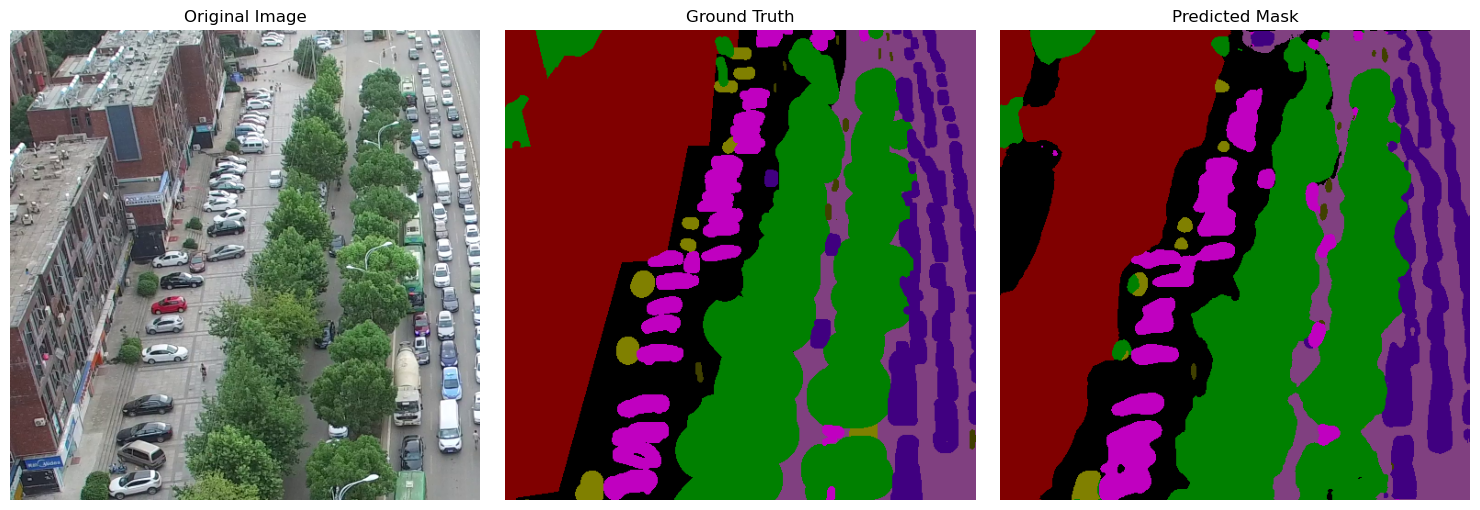

In [53]:
print("Sample: ", test_dataset.image_filenames[21])
model = load_model("best_model.pth", device)
model.to(device)

input_tensor, mask = test_dataset[21]
mask = postprocess_mask(mask)

with torch.no_grad():
    output = model(input_tensor[None, ...].to(device))
    pred_mask = output.argmax(dim=1)

original_image = input_tensor.permute(1,2,0).numpy()

pred_rgb = postprocess_mask(pred_mask)
visualize_inference(original_image, pred_rgb, mask)